# Assignment 4
### Shah Harshil Hardik
### Roll No. 23110132

In [ ]:
from pydriller import Repository
import pandas as pd
import os
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
create_react_app = "https://github.com/facebook/create-react-app"
gemini_cli = "https://github.com/google-gemini/gemini-cli"
deepspeed = "https://github.com/deepspeedai/DeepSpeed"

#### Function to get the commit details using a specified diff algorithm

In [4]:
def get_commit_df(url, diff_method="myers", clone_dir="repos/clone"):
    if not os.path.exists(clone_dir):
        os.makedirs(clone_dir)
    histogram_diff = diff_method == "histogram"
    rows = []
    for commit in Repository(url, clone_repo_to=clone_dir, histogram_diff=histogram_diff).traverse_commits():
        commit_sha = commit.hash
        commit_message = commit.msg
        parent_commit_sha = commit.parents[0] if commit.parents else None
        for modified_file in commit.modified_files:
            rows.append({
                "old_file_path": modified_file.old_path,
                "new_file_path": modified_file.new_path,
                "commit_sha": commit_sha,
                "parent_commit_sha": parent_commit_sha,
                "commit_message": commit_message,
                "diff": modified_file.diff_parsed,
            })
    print(f"{diff_method} diff extracted.")
    return rows


#### Function to merge 2 dataframes - one with Myers Diff and another with Histogram

In [ ]:
def merge_to_df(diff_myers, diff_histogram):
    myers_df = pd.DataFrame(diff_myers)
    histogram_df = pd.DataFrame(diff_histogram)
    # Using inner join on the common columns to merge the dataframes
    merged_df = pd.merge(myers_df, histogram_df, on=["old_file_path", "new_file_path", "commit_sha", "parent_commit_sha", "commit_message"], suffixes=("_myers", "_histogram"))
    return merged_df

In [ ]:
# Utility Function to extract repo name from URL
def extract_name(repo_url):
    return repo_url.split("/")[-1]

#### Function to get both the diff versions and analyze discrepency

In [ ]:
def process_repo(repo_url):
    repo_name = extract_name(repo_url)
    if (os.path.exists(f"./{repo_name}_df.csv")):
        print(f"{repo_name}_df.csv already exists.")
        return
    rows_myers = get_commit_df(repo_url, diff_method="myers")
    rows_histogram = get_commit_df(repo_url, diff_method="histogram")

    df = merge_to_df(rows_myers, rows_histogram)
    df['discrepancy'] = df['diff_myers'] != df['diff_histogram']
    df.to_csv(f"{repo_name}_df.csv", index=False)
    print(f"{repo_name}_df.csv created.")

In [17]:
process_repo(create_react_app)
process_repo(gemini_cli)
process_repo(deepspeed)

myers diff extracted.
histogram diff extracted.
create-react-app_df.csv created.
myers diff extracted.
histogram diff extracted.
gemini-cli_df.csv created.
myers diff extracted.
histogram diff extracted.
DeepSpeed_df.csv created.


### Function to get Statistical Inferences from the data

In [ ]:
def get_statistics(repo_name):
    # Load dataset
    df = pd.read_csv(f"{repo_name}_df.csv")

    total_files = df.shape[0]
    mismatches = df[df["discrepancy"] == True]

    # Categorize mismatches
    stats = {
        "Source Code": mismatches[
            mismatches["new_file_path"].str.contains(r"\.py$|\.c$|\.cpp$|\.ts$|\.js$", na=False) & ~mismatches["new_file_path"].str.contains(r'test|tests', na=False)
        ].shape[0],
        
        "Test Code": mismatches[
            mismatches["new_file_path"].str.contains(r"test|tests", case=False, na=False)
        ].shape[0],
        
        "README": mismatches[
            mismatches["new_file_path"].str.contains(r"README", case=False, na=False)
        ].shape[0],
        
        "LICENSE": mismatches[
            mismatches["new_file_path"].str.contains(r"LICENSE", case=False, na=False)
        ].shape[0],
    }

    # Convert to DataFrame
    stats_df = pd.DataFrame(list(stats.items()), columns=["File Type", "#Mismatches"])
    stats_df["% of Total Files"] = (stats_df["#Mismatches"] / total_files * 100).round(2)

    # Plot bar chart (absolute mismatches)
    plt.figure(figsize=(5, 5))
    plt.bar(stats_df["File Type"], stats_df["#Mismatches"], color="skyblue", edgecolor="black")
    plt.title(f"Mismatches Statistics for {repo_name}", fontsize=14)
    plt.xlabel("File Type")
    plt.ylabel("#Mismatches")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

    return stats_df


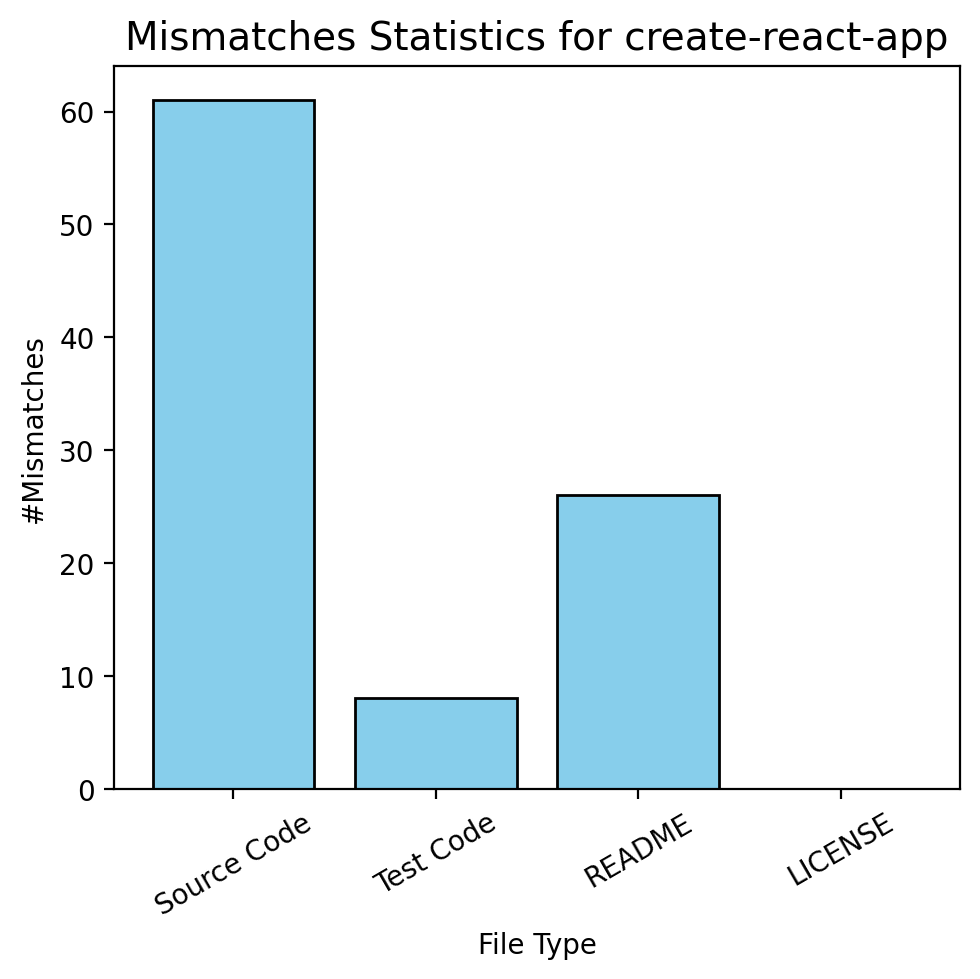

,File Type,#Mismatches,% of Total Files
0,Source Code,61,0.80
1,Test Code,8,0.11
2,README,26,0.34
3,LICENSE,0,0.00


In [16]:
get_statistics("create-react-app")

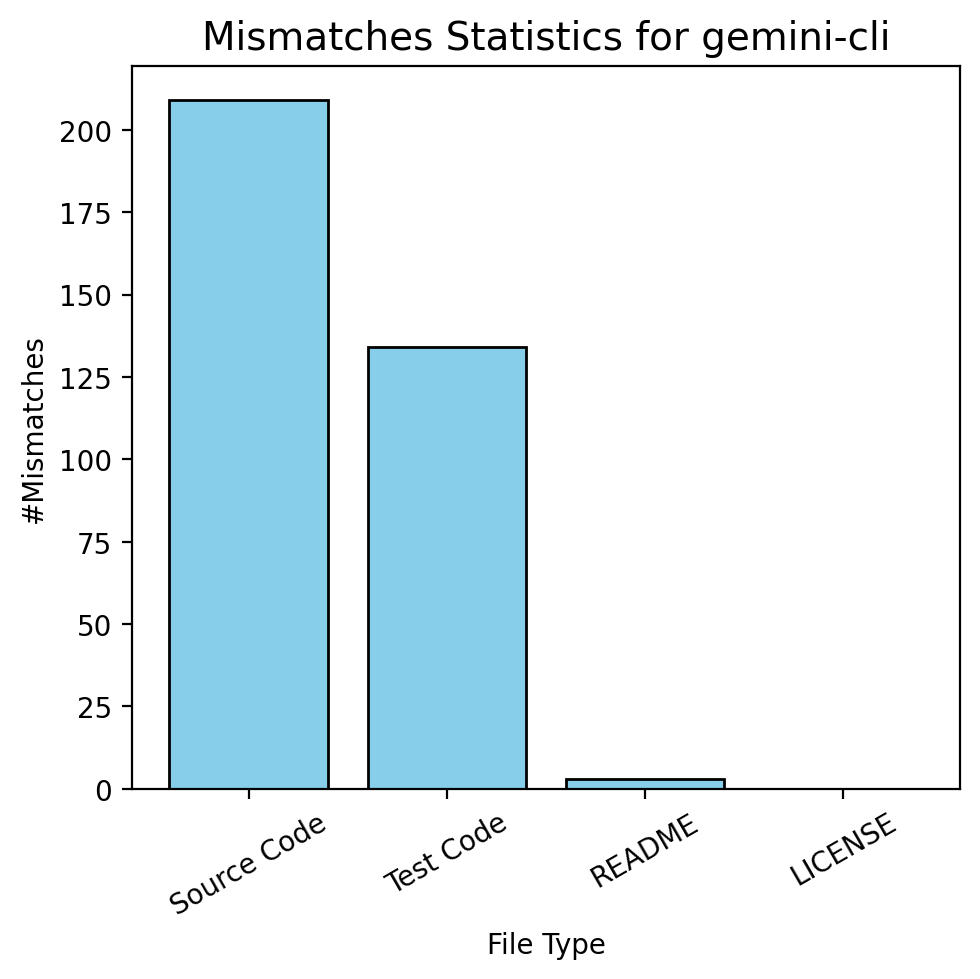

,File Type,#Mismatches,% of Total Files
0,Source Code,209,2.22
1,Test Code,134,1.42
2,README,3,0.03
3,LICENSE,0,0.00


In [17]:
get_statistics("gemini-cli")

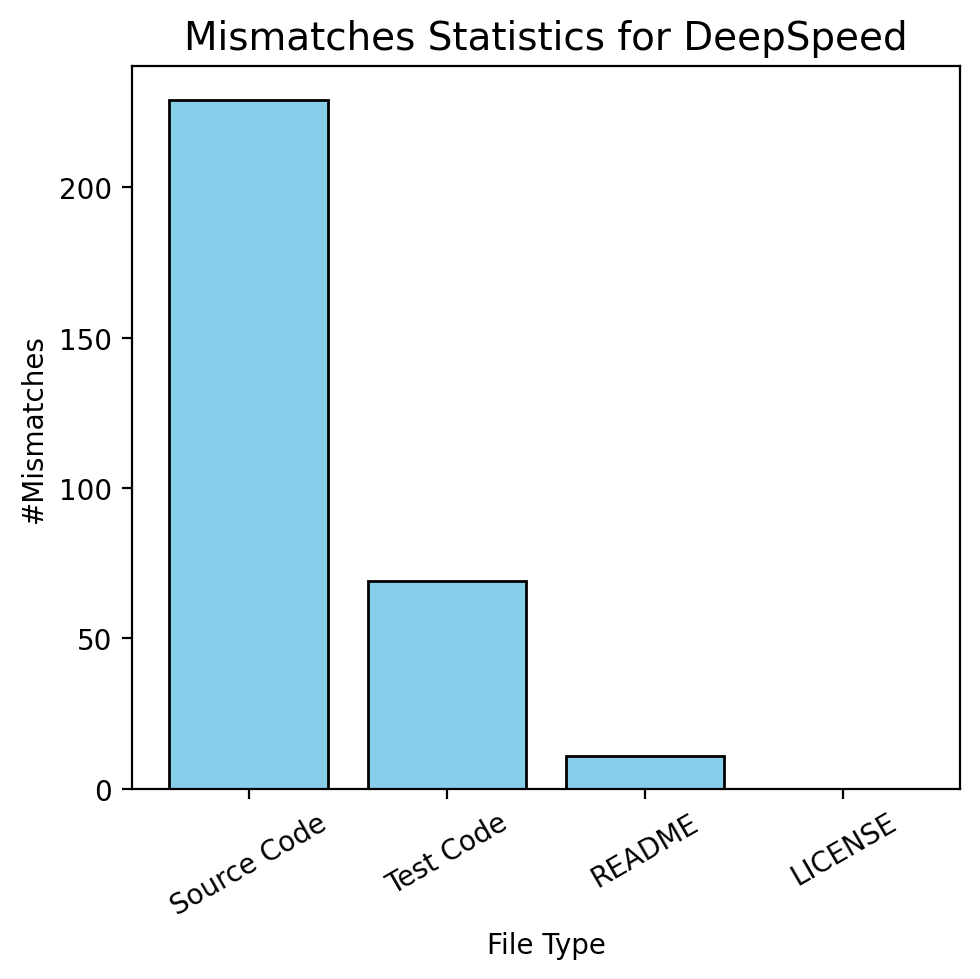

,File Type,#Mismatches,% of Total Files
0,Source Code,229,1.91
1,Test Code,69,0.58
2,README,11,0.09
3,LICENSE,0,0.00


In [18]:
get_statistics("DeepSpeed")